In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import numpy as np 
import pandas as pd
import os
import shutil
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import Xception

In [64]:
df = pd.read_csv('data_llhajbbbb.csv' )

AUTO = tf.data.experimental.AUTOTUNE

In [65]:
df.columns

Index(['image', 'lebels'], dtype='object')

In [66]:
df.head()

,image,lebels
0,new_data0.jpeg,rouille
1,new_data1.jpeg,rouille
2,new_data2.jpeg,rouille
3,new_data3.jpeg,rouille
4,new_data4.jpeg,rouille


In [67]:
a=df.copy()
a=pd.get_dummies(a['lebels'])
df1=pd.concat([df, a], axis=1)
df1.head()

,image,lebels,acariens,chancre fusicocum,coryneum,faux tigre,othyorinques,polystigma,puceron noir,puceron vert,rouille,scolytes
0,new_data0.jpeg,rouille,0,0,0,0,0,0,0,0,1,0
1,new_data1.jpeg,rouille,0,0,0,0,0,0,0,0,1,0
2,new_data2.jpeg,rouille,0,0,0,0,0,0,0,0,1,0
3,new_data3.jpeg,rouille,0,0,0,0,0,0,0,0,1,0
4,new_data4.jpeg,rouille,0,0,0,0,0,0,0,0,1,0


<ipython-input-68-4a7a286868c5>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pcts=df1.mean()


<AxesSubplot:ylabel='None'>

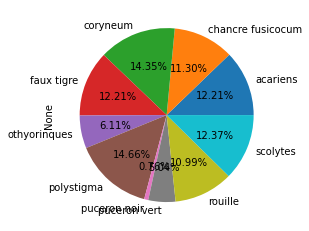

In [68]:
pcts=df1.mean()
pcts.plot(kind = 'pie',autopct='%1.2f%%')

In [69]:
data=df1[df1['puceron noir']!=1]

In [70]:
data=data[data['puceron vert']!=1]

In [71]:
data.drop(columns='lebels', inplace=True)

data.shape

(617, 11)

In [72]:
data.drop(columns=['puceron noir','puceron vert'],inplace=True)

In [73]:
data.head()

,image,acariens,chancre fusicocum,coryneum,faux tigre,othyorinques,polystigma,rouille,scolytes
0,new_data0.jpeg,0,0,0,0,0,0,1,0
1,new_data1.jpeg,0,0,0,0,0,0,1,0
2,new_data2.jpeg,0,0,0,0,0,0,1,0
3,new_data3.jpeg,0,0,0,0,0,0,1,0
4,new_data4.jpeg,0,0,0,0,0,0,1,0


In [74]:
data.columns

Index(['image', 'acariens', 'chancre fusicocum', 'coryneum', 'faux tigre',
       'othyorinques', 'polystigma', 'rouille', 'scolytes'],
      dtype='object')

<ipython-input-75-e50005ee8130>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pcts=data.mean()


<AxesSubplot:ylabel='None'>

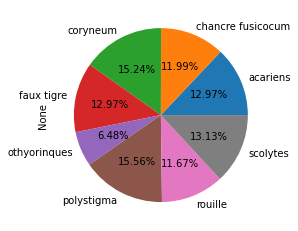

In [75]:
pcts=data.mean()
pcts.plot(kind = 'pie',autopct='%1.2f%%')

In [76]:
img_size={'height': 960,
         'width': 1280 }

In [77]:
data.shape

(617, 9)

In [78]:
path='path/'
data_path=data.image.apply(lambda x: path +x).values

(1280, 958, 3)


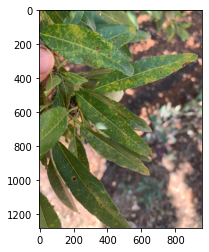

In [79]:
from matplotlib import pyplot as plt

img = plt.imread(path+'new_data1.jpeg')
print(img.shape)
plt.imshow(img)

In [80]:
len(data_path)

617

XML

In [81]:
data_labels = data.loc[:, ['acariens','scolytes','othyorinques', 'chancre fusicocum', 'faux tigre', 'polystigma','coryneum', 'rouille']].values

In [82]:
train_paths, test_paths, train_labels, test_labels =train_test_split(data_path, data_labels, test_size=0.2, random_state=42)


In [83]:
len(test_paths)

124

In [84]:
IMG_SIZE=300
def decode_image(filename, label=None, IMG_SIZE=(IMG_SIZE, IMG_SIZE)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, IMG_SIZE)
    
    if label is None:
        return image
    else:
        return image, label


def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [85]:
BATCH_SIZE = 16

train_dataset = (
tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_paths,test_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    
)

In [86]:
LR_START = 0.00001
LR_MAX = 0.00005 
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 6
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [87]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow import keras

Dense_net = keras.models.load_model('new_modelss')

In [88]:
Dense_net.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 296, 296, 32)      2432      
_________________________________________________________________
batch_normalization_23 (Batc (None, 296, 296, 32)      96        
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 292, 292, 128)     102528    
_________________________________________________________________
batch_normalization_24 (Batc (None, 292, 292, 128)     384       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 146, 146, 128)     0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 146, 146, 128)     0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 144, 144, 32)     

In [89]:
x = Dense_net.get_layer("dropout_20").output
x=Dense(50,activation='relu')(x) 
x=Dense(25,activation='relu')(x)
x = tf.keras.layers.Dense(8, activation='softmax')(x)
model =  keras.Model(inputs = Dense_net.input,outputs=x)
model.compile( optimizer= 'adam',loss="categorical_crossentropy", metrics=["accuracy"])

In [90]:
history=model.fit(
    train_dataset,
    steps_per_epoch=data_labels.shape[0] // BATCH_SIZE,
    epochs=60,
    validation_data=test_dataset
    )

Epoch 1/60
38/38 [==============================] - 29s 512ms/step - loss: 2.1118 - accuracy: 0.1826 - val_loss: 2.0975 - val_accuracy: 0.1694
Epoch 2/60
38/38 [==============================] - 19s 506ms/step - loss: 2.0012 - accuracy: 0.2220 - val_loss: 1.9307 - val_accuracy: 0.2661
Epoch 3/60
38/38 [==============================] - 19s 511ms/step - loss: 1.8800 - accuracy: 0.2467 - val_loss: 1.9274 - val_accuracy: 0.1694
Epoch 4/60
38/38 [==============================] - 20s 515ms/step - loss: 1.8432 - accuracy: 0.2878 - val_loss: 1.8415 - val_accuracy: 0.1774
Epoch 5/60
38/38 [==============================] - 19s 513ms/step - loss: 1.8057 - accuracy: 0.2977 - val_loss: 1.8755 - val_accuracy: 0.2097
Epoch 6/60
38/38 [==============================] - 20s 517ms/step - loss: 1.7768 - accuracy: 0.3076 - val_loss: 1.8361 - val_accuracy: 0.1774
Epoch 7/60
38/38 [==============================] - 20s 517ms/step - loss: 1.7082 - accuracy: 0.3569 - val_loss: 1.7535 - val_accuracy: 0.2661

In [91]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        #plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

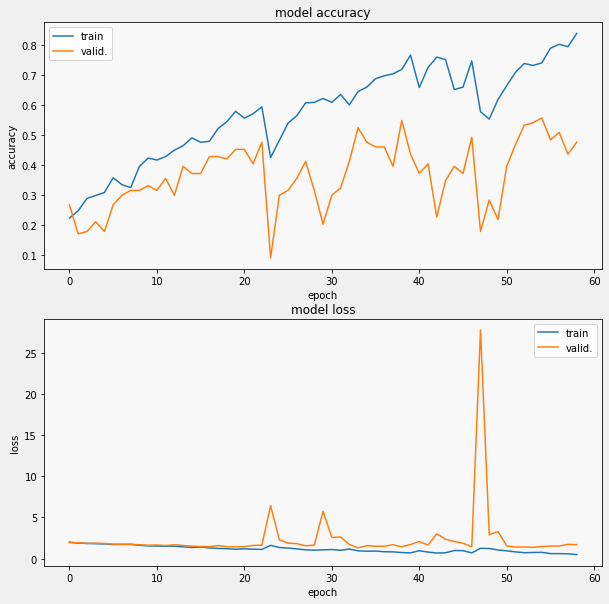

In [92]:
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

In [93]:
import pickle
with open('training_log/newmodel_300px_withhhhhdenselayer_620data_60epochs_8output.pkl', 'wb') as output:
        pickle.dump(history.history, output)